,Fast,Slow,Signal,Final,Trades
0,8,26,6,995076.50,1272
1,12,20,12,991111.75,1279
2,8,32,6,990787.25,1263
3,16,20,9,989961.25,1268
4,16,20,12,989074.00,1283
5,8,20,12,988841.50,1263
6,16,26,9,988224.25,1291
7,12,26,12,988162.00,1289
8,8,26,9,988112.00,1255
9,8,20,6,987671.00,1291


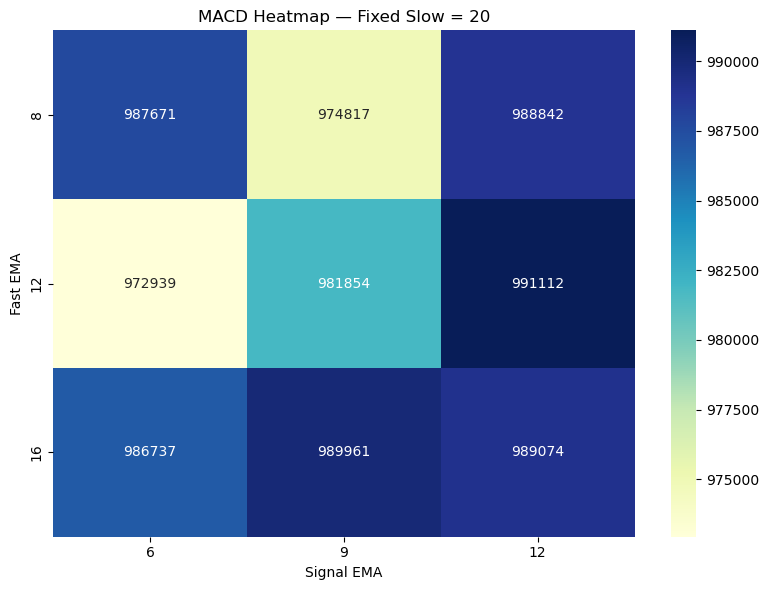

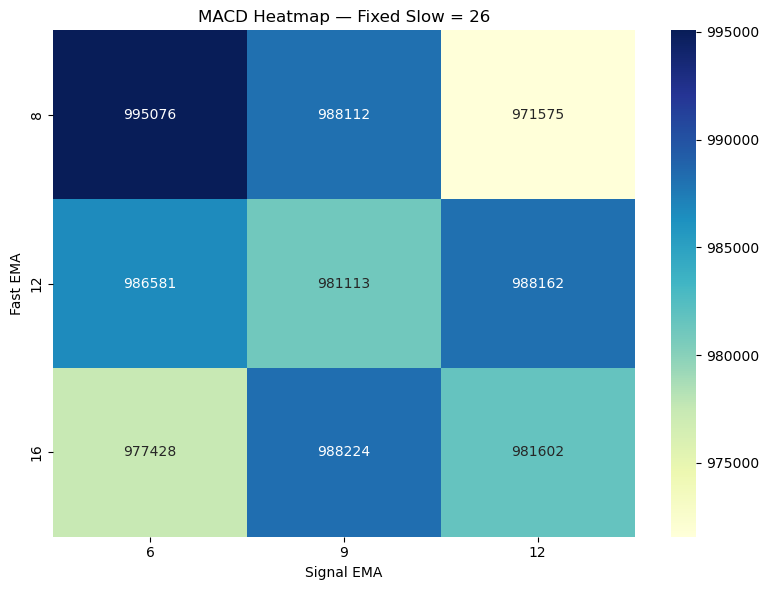

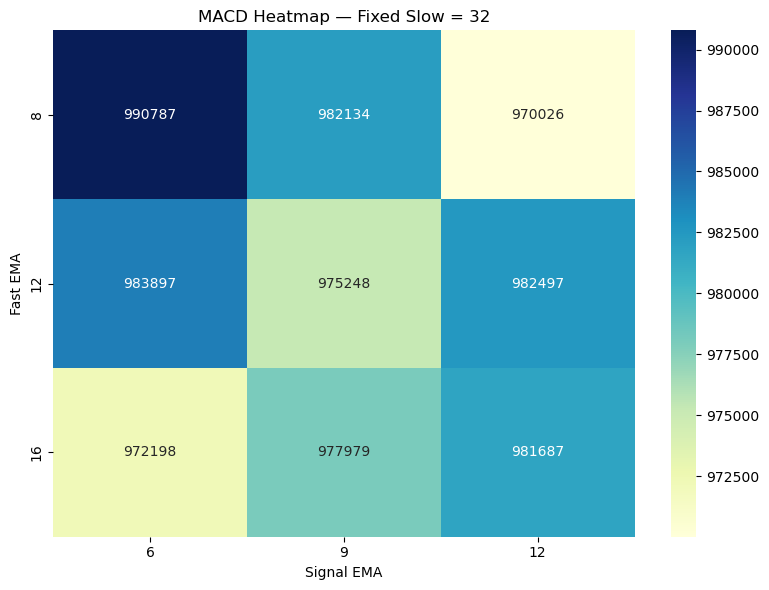

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# ─── LOAD AND PREP DATA ─────────────────────────────────────────
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')




# MACD parameter grid
fast_list = [8, 12, 16]
slow_list = [20, 26, 32]
signal_list = [6, 9, 12]

# Constants
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY = 500

# Precompute indicators on fresh copy
df_macd = df.copy()
df_macd['VOL_S'] = df_macd['volume'].rolling(VOL_WIN).mean()
df_macd['VOL_L'] = df_macd['volume'].rolling(VOL_MED_WIN).mean()
df_macd['VOL_RATIO'] = df_macd['VOL_S'] / df_macd['VOL_L']

tr1 = df_macd['high'] - df_macd['low']
tr2 = (df_macd['high'] - df_macd['close'].shift()).abs()
tr3 = (df_macd['low'] - df_macd['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df_macd['ATR'] = tr.rolling(14).mean()

results = []

for fast in fast_list:
    for slow in slow_list:
        if slow <= fast:
            continue  # invalid combination
        for sig_p in signal_list:
            df_macd['EMA_fast'] = df_macd['close'].ewm(span=fast).mean()
            df_macd['EMA_slow'] = df_macd['close'].ewm(span=slow).mean()
            df_macd['MACD'] = df_macd['EMA_fast'] - df_macd['EMA_slow']
            df_macd['Signal'] = df_macd['MACD'].ewm(span=sig_p).mean()

            df_macd['Cross'] = np.where(
                df_macd['MACD'] > df_macd['Signal'], 1,
                np.where(df_macd['MACD'] < df_macd['Signal'], -1, 0)
            )

            cash, pos = CASH0, 0
            stop = target = None
            equity = []
            num_trades = 0

            for _, row in df_macd.iterrows():
                price = row['close']
                atr = row['ATR']
                sig = row['Cross']
                vol_ratio = row['VOL_RATIO']

                if pos > 0 and (price >= target or price <= stop):
                    cash += pos * price
                    pos = 0
                elif pos < 0 and (price <= target or price >= stop):
                    cash -= -pos * price
                    pos = 0

                if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
                    if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                        qty = int((cash * RISK_PCT) / price)
                        qty = min(qty, MAX_QTY)

                        if sig == 1:
                            cash -= qty * price
                            pos = qty
                            stop = price - 2.0 * atr
                            target = price + 3.0 * atr
                            num_trades += 1
                        elif sig == -1:
                            cash += qty * price
                            pos = -qty
                            stop = price + 2.0 * atr
                            target = price - 3.0 * atr
                            num_trades += 1

                equity.append(cash if pos == 0 else cash + pos * price)

            if equity:
                results.append({
                    'Fast': fast,
                    'Slow': slow,
                    'Signal': sig_p,
                    'Final': equity[-1],
                    'Trades': num_trades
                })

# Summarize
df_macd_res = pd.DataFrame(results)

# Summary table
macd_summary = df_macd_res.sort_values('Final', ascending=False).reset_index(drop=True)
display(macd_summary.head(10))

# Heatmap (Fast vs Signal at fixed Slow)
for fixed_slow in sorted(df_macd_res['Slow'].unique()):
    pivot = df_macd_res[df_macd_res['Slow'] == fixed_slow].pivot(
        index='Fast', columns='Signal', values='Final'
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f"MACD Heatmap — Fixed Slow = {fixed_slow}")
    plt.xlabel('Signal EMA')
    plt.ylabel('Fast EMA')
    plt.tight_layout()
    plt.show()


In [5]:
print(f"Number of observations in dataset: {len(df)}")


Number of observations in dataset: 69055


/var/folders/lz/wycfcgp14vg5s2s48232j0y80000gn/T/ipykernel_30936/2553305548.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoom_df['MACD_vis'] = zoom_df['MACD'] * 2
/var/folders/lz/wycfcgp14vg5s2s48232j0y80000gn/T/ipykernel_30936/2553305548.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoom_df['Signal_vis'] = zoom_df['Signal_Line'] * 2


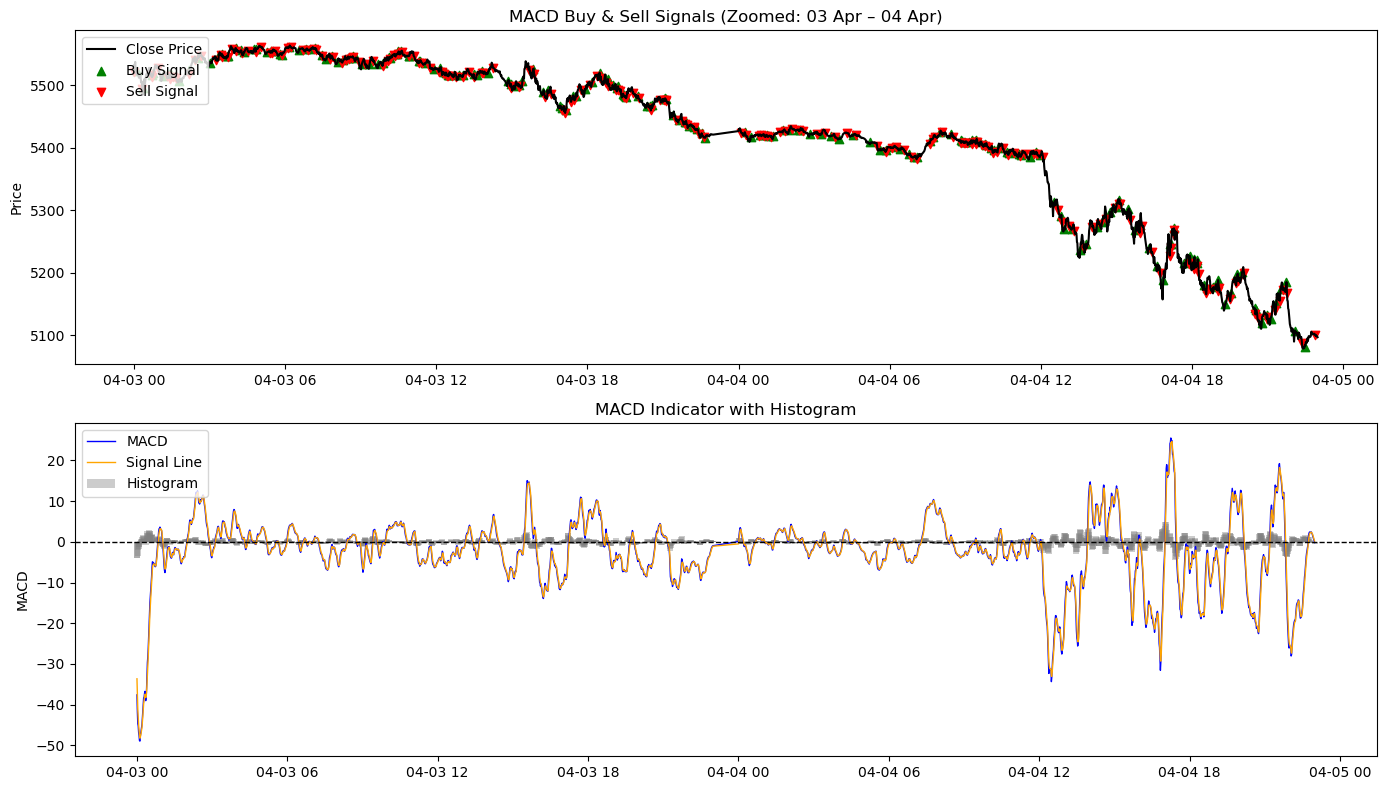

In [7]:
import matplotlib.pyplot as plt

# MACD parameters
fast, slow, sig_p = 8, 35, 3  # or your optimized (8, 26, 9)
df_macd = df.copy()

# MACD indicators
df_macd['EMA_fast'] = df_macd['close'].ewm(span=fast).mean()
df_macd['EMA_slow'] = df_macd['close'].ewm(span=slow).mean()
df_macd['MACD'] = df_macd['EMA_fast'] - df_macd['EMA_slow']
df_macd['Signal_Line'] = df_macd['MACD'].ewm(span=sig_p).mean()
df_macd['Histogram'] = df_macd['MACD'] - df_macd['Signal_Line']

# Generate signals
df_macd['Signal_MACD'] = 0
df_macd.loc[(df_macd['MACD'].shift(1) < df_macd['Signal_Line'].shift(1)) & 
            (df_macd['MACD'] > df_macd['Signal_Line']), 'Signal_MACD'] = 1
df_macd.loc[(df_macd['MACD'].shift(1) > df_macd['Signal_Line'].shift(1)) & 
            (df_macd['MACD'] < df_macd['Signal_Line']), 'Signal_MACD'] = -1

# Zoom window
zoom_df = df_macd.loc["2025-04-03":"2025-04-04"]
zoom_df['MACD_vis'] = zoom_df['MACD'] * 2
zoom_df['Signal_vis'] = zoom_df['Signal_Line'] * 2


# ... keep df_macd preparation and signal logic as before

# MACD plot with slim histogram bars
plt.figure(figsize=(14, 8))

# Top: price with buy/sell signals
plt.subplot(2, 1, 1)
plt.plot(zoom_df.index, zoom_df['close'], label='Close Price', linewidth=1.5, color='black')
plt.scatter(zoom_df.index[zoom_df['Signal_MACD'] == 1], zoom_df['close'][zoom_df['Signal_MACD'] == 1],
            marker='^', color='green', label='Buy Signal')
plt.scatter(zoom_df.index[zoom_df['Signal_MACD'] == -1], zoom_df['close'][zoom_df['Signal_MACD'] == -1],
            marker='v', color='red', label='Sell Signal')
plt.title("MACD Buy & Sell Signals (Zoomed: 03 Apr – 04 Apr)")
plt.ylabel("Price")
plt.legend(loc="upper left")

# Bottom: MACD lines + thin histogram bars
plt.subplot(2, 1, 2)
plt.plot(zoom_df.index, zoom_df['MACD'], label='MACD', color='blue', linewidth=1)
plt.plot(zoom_df.index, zoom_df['Signal_Line'], label='Signal Line', color='orange', linewidth=1)

# Slim histogram bars
plt.bar(zoom_df.index, zoom_df['Histogram'], label='Histogram',
        color='grey', alpha=0.4, width=0.01)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("MACD Indicator with Histogram")
plt.ylabel("MACD")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()
